In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
aftermsgs = [3000]
datapaths = ["dp", "mux"]

def read_files():
    for a in aftermsgs:
        for dp in datapaths:
            try:
                df = pd.read_csv(f"../swap-68f71c8/swap{dp}-aftermsgs_{a}-openloop_1ms.txt", sep=" ")
                df["datapath"] = dp
                df["swapdelay"] = a
                yield df
            except Exception as e:
                print(e)
                continue
            
df = pd.concat(read_files())
df

,send_time_us,maybe_recv_time,maybe_rtt_us,datapath,swapdelay
0,1498,2556,1058,dp,3000
1,1797,2946,1149,dp,3000
2,1799,3179,1380,dp,3000
3,1912,3172,1260,dp,3000
4,2503,2560,57,dp,3000
...,...,...,...,...,...
23995,5999924,5999941,17,mux,3000
23996,6000514,6000532,18,mux,3000
23997,6000772,6000804,32,mux,3000
23998,6000801,6000815,14,mux,3000


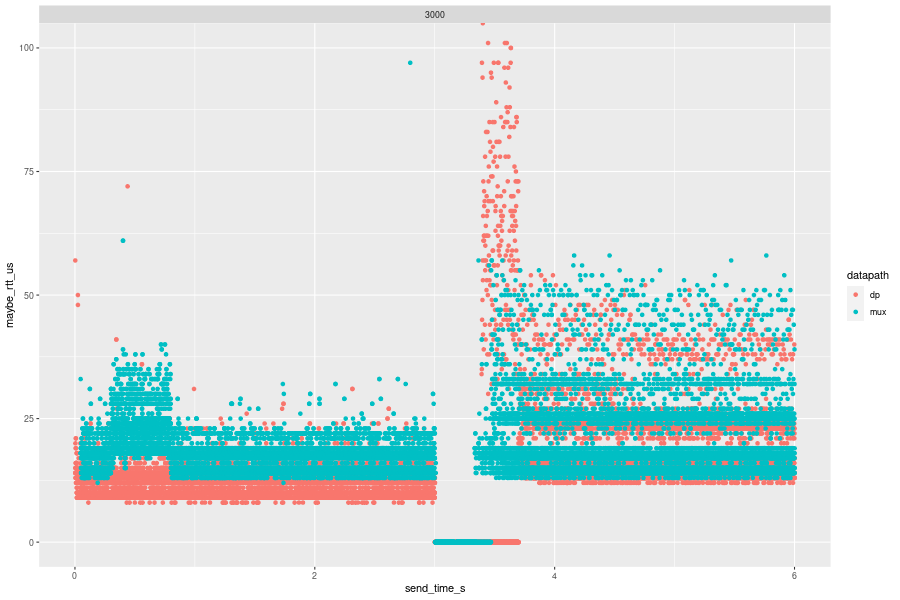

In [3]:
%%R -i df -w 900 -h 600

library(ggplot2)

df$send_time_s <- df$send_time_us / 1e6

ggplot(df, aes(x=send_time_s, y=maybe_rtt_us, color=datapath)) +
  geom_point() +
  coord_cartesian(ylim=c(0, 100)) +
  facet_wrap(~swapdelay)

In [59]:
df_discrete = df
df_discrete["time_bin"] = np.floor(df_discrete["send_time_us"] / 1e5)
df_discrete["maybe_rtt_us"].replace(0, np.nan, inplace=True)
df_discrete = df_discrete[["time_bin", "swapdelay", "datapath", "maybe_rtt_us"]].groupby(["time_bin", "swapdelay", "datapath"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
df_discrete.columns = [f"{s}_{t}" for s,t in df_discrete.columns.values]
df_discrete.reset_index(inplace=True)
df_discrete

,time_bin,swapdelay,datapath,maybe_rtt_us_0.05,maybe_rtt_us_0.25,maybe_rtt_us_0.5,maybe_rtt_us_0.75,maybe_rtt_us_0.95
0,0.0,3000,dp,9.0,11.00,13.0,14.00,19.00
1,0.0,3000,mux,14.0,17.75,23.0,22278.00,42006.25
2,1.0,3000,dp,9.0,11.00,13.0,14.00,15.00
3,1.0,3000,mux,14.0,14.00,17.0,19.00,23.00
4,2.0,3000,dp,9.0,10.00,13.0,14.00,15.00
...,...,...,...,...,...,...,...,...
117,58.0,3000,mux,14.0,15.00,18.0,24.00,33.00
118,59.0,3000,dp,13.0,14.00,16.0,21.00,25.00
119,59.0,3000,mux,14.0,15.00,18.0,24.00,32.00
120,60.0,3000,dp,13.0,13.00,13.0,15.50,21.50


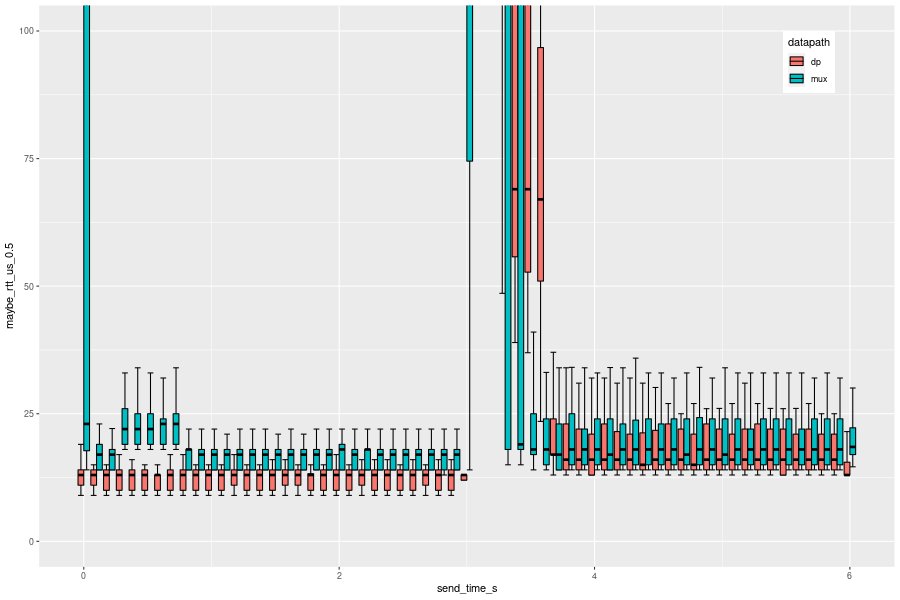

In [62]:
%%R -i df_discrete -w 900 -h 600

library(ggplot2)

df_discrete$send_time_s <- df_discrete$time_bin / 10
    
ggplot(df_discrete, aes(x=send_time_s, fill=datapath, group=interaction(send_time_s, datapath))) +
  geom_errorbar(aes(ymin=maybe_rtt_us_0.05, ymax = maybe_rtt_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=maybe_rtt_us_0.25, y=maybe_rtt_us_0.5, ymax = maybe_rtt_us_0.75), position="dodge") +
  coord_cartesian(ylim=c(0,100)) +
  theme(legend.position=c(0.9, 0.9))

In [61]:
df_discrete.to_csv('dpswap-68f71c8.csv')

In [11]:
from datetime import datetime, timedelta

def read_log(log):
    with open(log) as f:
        start = None
        for line in f:
            try:
                sp = line.strip().split()
                t = datetime.strptime(sp[0], "%Y-%m-%dT%H:%M:%S.%fZ")
                if start == None:
                    start = t
                delta_us = (t - start) / timedelta(microseconds = 1)
                yield {'t_us': delta_us, 'msg': ' '.join(sp[1:])}
            except:
                pass
            
log1 = '../swapmux-aftermsgs_3000-openloop_1ms.log'
tl1 = pd.DataFrame.from_records(read_log(log1))
tl1['datapath'] = 'mutex'
log2 = '../swapdp-aftermsgs_3000-openloop_1ms.log'
tl2 = pd.DataFrame.from_records(read_log(log2))
tl2['datapath'] = 'fast'

tl = pd.concat([tl1, tl2])
tl

,t_us,msg,datapath
0,0.0,INFO server{thread_idx=3}:connection{port=4242...,mutex
1,26.0,DEBUG server{thread_idx=3}:connection{port=424...,mutex
2,7386.0,DEBUG server{thread_idx=3}:connection{port=424...,mutex
3,7582.0,DEBUG server{thread_idx=3}:connection{port=424...,mutex
4,7777.0,INFO dpdk_wrapper::wrapper: DPDK available por...,mutex
5,114626.0,INFO dpdk_wrapper::wrapper: Link Up port_id=0 ...,mutex
6,347170.0,DEBUG server{thread_idx=3}:connection{port=424...,mutex
7,361603.0,DEBUG server{thread_idx=3}:connection{port=424...,mutex
8,362425.0,DEBUG server{thread_idx=3}:connection{port=424...,mutex
9,362445.0,DEBUG server{thread_idx=3}:connection{port=424...,mutex


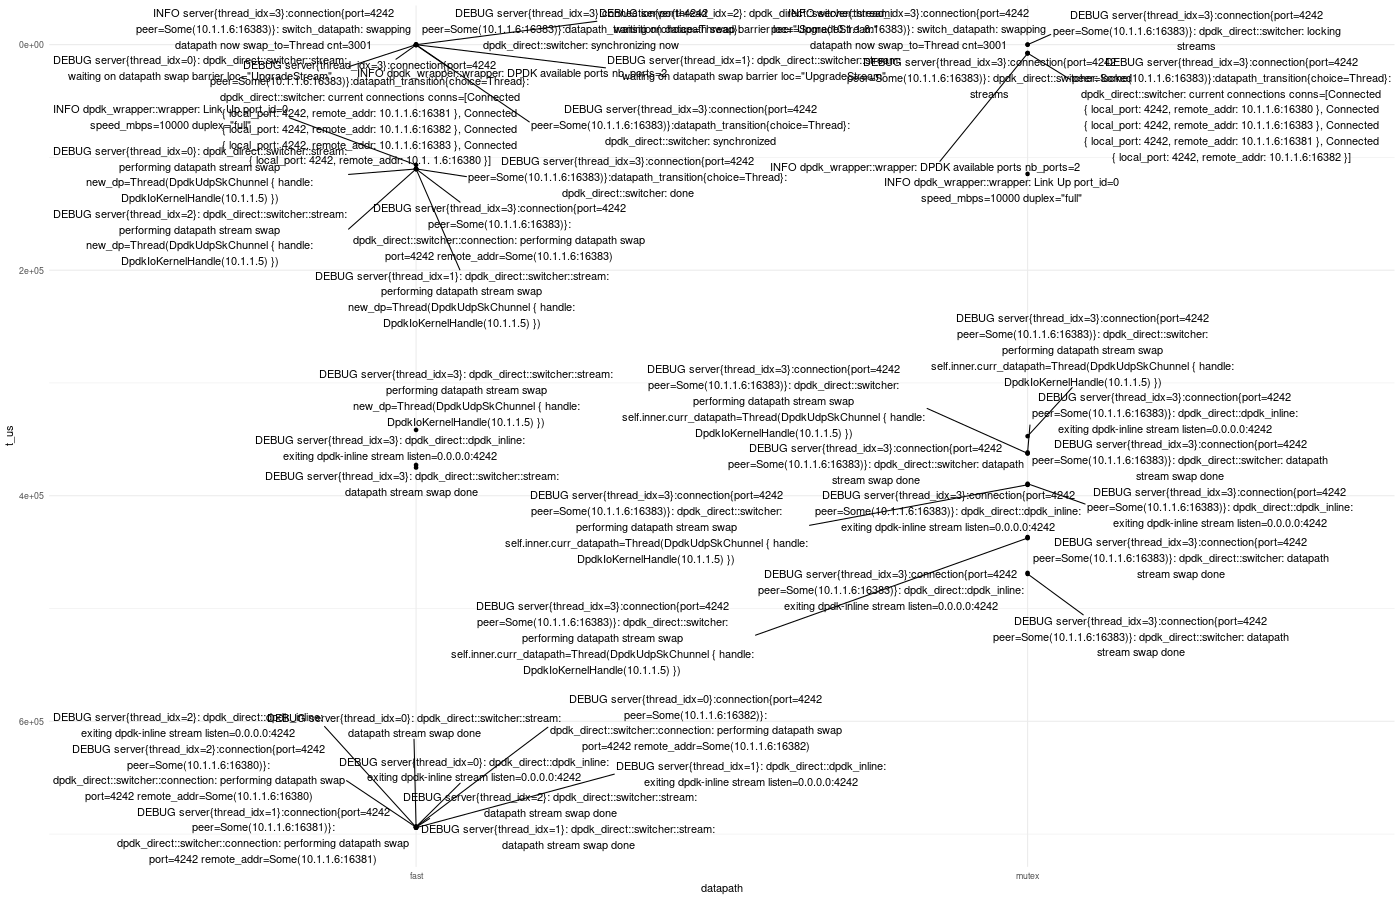

In [45]:
%%R -i tl -w 1400 -h 900

library(stringr)
library(ggrepel)

tl$msg_w <- stringr::str_wrap(tl$msg, 60)
ggplot(tl, aes(y=t_us, x=datapath, label=msg_w)) + 
  geom_text_repel(max.overlaps=20) + 
  geom_point() + 
  scale_y_reverse() + 
  theme_minimal()